In [13]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import grad, Variable

print(torch.backends.cuda.matmul.allow_tf32)
torch.backends.cuda.matmul.allow_tf32 = False

np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

False
cuda


In [10]:
class Net(nn.Module):
    def __init__(self, hidden_dim = 20, n_hidden = 8):
        super(Net, self).__init__()
        hiddens = nn.ModuleList([])
        
        hiddens.append(nn.Linear(2, hidden_dim))
        hiddens.append(nn.Tanh())
        for _ in range(n_hidden):
            hiddens.append(nn.Linear(hidden_dim, hidden_dim))
            hiddens.append(nn.Tanh())
        hiddens.append(nn.Linear(hidden_dim, 1))
        self.hiddens = hiddens        
        
    def forward(self, xt):
        out = xt
        for layer in self.hiddens:
            out = layer(out)     
        return out

class PINN:
    hidden_dim = 20
    n_hidden = 8
    nu = 0.01 / np.pi
    iter = 0
    def __init__(self):
        self.net = Net(self.hidden_dim, self.n_hidden).to(device)
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        self.losses = []
        # self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3,
        #                                  betas=(0.9, 0.9))

    def u(self, xt):
        return self.net(xt)

    def u_f(self, xt):
        x = Variable(xt[:, 0:1], requires_grad=True)
        t = Variable(xt[:, 1:2], requires_grad=True)
        xt = torch.cat((x,t), axis = 1)
        u = self.net(xt)
        u_t = grad(u.sum(), t, create_graph=True)[0]
        u_x = grad(u.sum(), x, create_graph=True)[0]
        u_xx = grad(u_x.sum(), x, create_graph=True)[0]
        f = u_t + u * u_x - self.nu * u_xx
        return f

    def loss_fn(self):
        self.optimizer.zero_grad() 
        
        u_pred_bc = self.net(xt_bc)
        mse_u = torch.mean(torch.square(u_bc - u_pred_bc))
                
        f_pred_bc = self.u_f(xt_f)
        mse_f = torch.mean(torch.square(f_pred_bc)).to(device)
        
        loss = mse_u + mse_f

        loss.backward()

        print(
            f"\r{self.iter+1}, Loss : {loss.item():.3e}", end="",
        )
        self.losses.append(loss.item())
        if (self.iter+1) % 500 == 0:
            print("")
        self.iter += 1
        return loss

# Burger's Equation
$$
\begin{aligned} & u_t +uu_x -\left( \frac{0.01}{\pi} \right) u_{xx} = 0, \ \ \ \ \ x \in [-1, 1]
, \ \ t \in [0, 1] \\ \\ & u(x,0) = - \sin (\pi x ) \\ \\ & u(-1,t)=u(1,t)=0 \end{aligned}
$$

In [11]:
N_f = 10000
N_u = 100

upper_bound = {"x": 1, "t": 1}
lower_bound = {"x": -1, "t": 0}
x_min = -1
x_max = 1
t_min = 0
t_max = 1

# initial condition, u(x, 0) -> u = -sin(pi * x)
x_bc1 = np.linspace(x_min, x_max, N_u)[:, None]
t_bc1 = np.zeros((N_u, 1))
u_bc1 = -np.sin(np.pi * x_bc1)

# boundary condition, u(-1, t) = u(1, t) = 0
x_bc2 = -np.ones((N_u, 1))
t_bc2 = np.linspace(t_min, t_max, N_u)[:, None]
u_bc2 = np.zeros((N_u, 1))

x_bc3 = np.ones((N_u, 1))
t_bc3 = np.linspace(t_min, t_max, N_u)[:, None]
u_bc3 = np.zeros((N_u, 1))


x_bc = np.concatenate((x_bc1, x_bc2, x_bc3), axis=0)
t_bc = np.concatenate((t_bc1, t_bc2, t_bc3), axis=0)
xt_bc = np.concatenate((x_bc, t_bc), axis = 1)
u_bc = np.concatenate((u_bc1, u_bc2, u_bc3), axis=0)

xt_bc = torch.tensor(xt_bc, dtype=torch.float).to(device)
u_bc = torch.tensor(u_bc, dtype=torch.float).to(device)

# collocation

x_f = np.random.uniform(x_min, x_max, (N_f, 1))
t_f = np.random.uniform(t_min, t_max, (N_f, 1))
x_f = np.vstack([x_f, x_bc])
t_f = np.vstack([t_f, t_bc])

x_f = torch.tensor(x_f, dtype=torch.float).to(device)
t_f = torch.tensor(t_f, dtype=torch.float).to(device)
xt_f = torch.hstack([x_f, t_f])

In [12]:
pinn = PINN()
# for i in range(3000):
#     pinn.loss_fn()
#     pinn.optimizer.step()
pinn.optimizer.step(pinn.loss_fn)
# torch.save(pinn.net.state_dict(), "trained.pt")

500, Loss : 5.407e-02
1000, Loss : 3.736e-02
1500, Loss : 2.065e-02
1969, Loss : 6.163e-03

KeyboardInterrupt: 

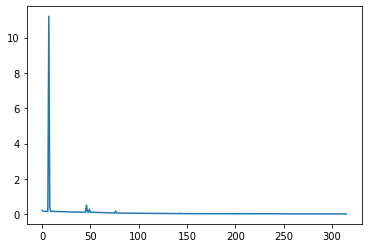

In [7]:
import matplotlib.pyplot as plt

plt.plot(pinn.losses)

C:\Users\user\AppData\Local\Temp/ipykernel_3168/693896744.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


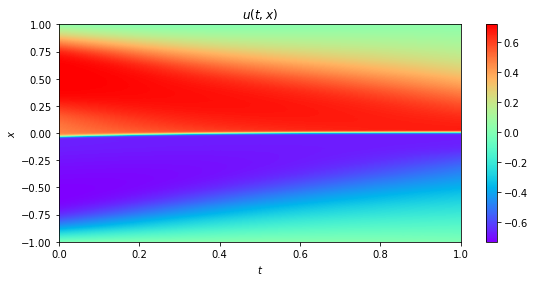

In [8]:
import matplotlib.pyplot as plt

x = np.arange(lower_bound["x"], upper_bound["x"]+0.01, 0.01)
t = np.arange(lower_bound["t"], upper_bound["t"]+0.01, 0.01)

x_mesh, t_mesh = np.meshgrid(x, t)
x_mesh = x_mesh.reshape((-1, 1))
t_mesh = t_mesh.reshape((-1, 1))

xt_mesh = np.concatenate([x_mesh, t_mesh], axis = 1)
xt_tensor = torch.tensor(xt_mesh, dtype = torch.float).to(device)

with torch.no_grad():
    u_pred = pinn.u(xt_tensor)
u_pred = u_pred.cpu().numpy().reshape((len(t), len(x))).T

fig, ax = plt.subplots(figsize=(9,4))
im = ax.imshow(u_pred, cmap = "rainbow", extent = [t.min(), t.max(), x.min(),
                                                   x.max()], aspect = "auto")
ax.set_xlabel("$t$")
ax.set_ylabel("$x$")
ax.set_title("$u(t,x)$")

fig.colorbar(im, ax = ax)
fig.show()

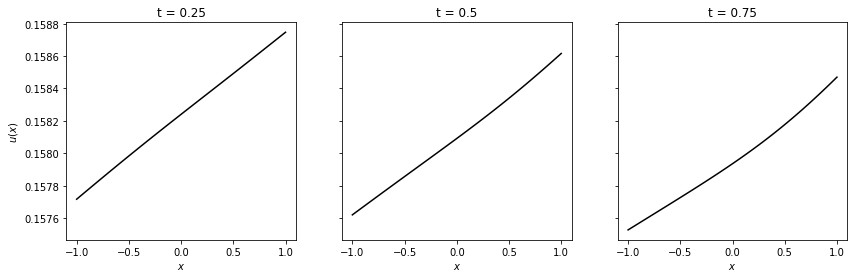

In [ ]:
xt_array = []
t_array = [0.25, 0.5, 0.75]
for t_ in t_array:
    x = np.linspace(x_min, x_max, 100)[:, None]
    t = t_ * np.ones((100, 1))
    xt = np.concatenate([x, t], axis = 1)
    xt_array.append(xt)

xt_array = np.array(xt_array, dtype = np.float32)
xt_tensor = torch.tensor(xt_array).to(device)

u_array = []

with torch.no_grad():
    for i in range(3):
        u_pred = pinn_burgers.u(xt_tensor[i])
        u_pred = u_pred.cpu().numpy()
        u_array.append(u_pred)

fig, axes = plt.subplots(1,3, figsize=(14,4), sharey=True)
axes[0].set_ylabel("$u(x)$")
for i in range(3):
    axes[i].plot(x, u_array[i], color = "black")
    axes[i].set_xlabel("$x$")
    axes[i].set_title(f"t = {t_array[i]}")


In [ ]:
class PINN_wave:
    hidden_dim = 20
    n_hidden = 8
    iter = 0
    nu = 0.01
    def __init__(self):
        self.net = Net(self.hidden_dim, self.n_hidden)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3,
                                         betas=(0.9, 0.9))

    def u(self, xt):
        return self.net(xt)

    def u_f(self, xt):
        x = xt[:, 0][:, None]
        t = xt[:, 1][:, None]
        xt = torch.cat((x,t), axis = 1)
        u = self.net(xt)
        u_t = grad(u.sum(), t, create_graph=True)[0]
        u_x = grad(u.sum(), x, create_graph=True)[0]
        u_xx = grad(u_x.sum(), x, create_graph=True)[0]
        u_tt = grad(u_t.sum(), t, create_graph=True)[0]                
        f = self.nu**2 * u_xx - u_tt
        return f

    def loss_fn(self):
        self.optimizer.zero_grad()
        
        xt_bc_1 = torch.tensor(order1_bc_xt, dtype=torch.float).to(device)
        xt_bc_2 = torch.tensor(order2_bc_xt, dtype=torch.float).to(device)
        u_bc_1 = torch.tensor(order1_bc_u, dtype=torch.float).to(device)
        
        u_pred_bc_1 = self.net(xt_bc_1)
        
        mse_u_1 = torch.mean(torch.square(u_pred_bc_1 - u_bc_1))        
        
        #
        x = Variable(xt_bc_2[:,0].unsqueeze(-1), requires_grad=True).to(device)
        t = Variable(xt_bc_2[:,1].unsqueeze(-1), requires_grad=True).to(device)
        xt = torch.cat([x, t], dim = 1)
        u_pred_bc_2 = self.net(xt)
        u_x_bc_2 = grad(u_pred_bc_2.sum(), x, create_graph=True)[0]
        mse_u_2 = torch.mean(torch.square(u_x_bc_2))
        mse_u = (mse_u_1 + mse_u_2) / 2

        x_f = np.random.uniform(lower_bound["x"], upper_bound["x"], (N_f, 1))
        x_f = Variable(torch.tensor(x_f, dtype=torch.float), requires_grad=True).to(device)        
        
        t_f = np.random.uniform(lower_bound["t"], upper_bound["t"], (N_f, 1))
        t_f = Variable(torch.tensor(t_f, dtype=torch.float), requires_grad=True).to(device)
        
        xt_f = torch.cat((x_f, t_f), dim=1)
        xt_f = torch.cat((xt_f, xt_bc_1, xt_bc_2), dim=0)
        f_pred_bc = self.u_f(xt_f)
        mse_f = torch.mean(torch.square(f_pred_bc)).to(device)
        
        loss = mse_u + mse_f

        loss.backward()
        self.optimizer.step()

        print(
            f"\r{self.iter+1}, Loss : {loss.item():.3e}", end="",
        )
        if (self.iter+1) % 500 == 0:
            print("")
        self.iter += 1
        return loss

# Wave Equation

$$
\begin{align}
a^2\frac{\partial^2 u}{\partial x^2} &= \frac{\partial^2 u}{\partial t^2}, \ \ \ \ \ x \in [0, L], t > 0 \\
u(0,t) &= 0,\ \ \  u(L,t) = 0,\ \ \  t > 0 \\
u(x,0) &= f(x),\ \ \ [\frac{\partial u}{\partial t}]_{t=0} = g(x) \\
f(x) &= sin(\pi x), \ \ \  g(x) = 0
\end{align}
$$

In [ ]:
N_f = 10000
N_u = 100
f = lambda x : np.sin(np.pi * x)

upper_bound = {"x" : 3, "t" : 1}
lower_bound = {"x" : 0, "t" : 0}

x_bc1 = np.zeros((N_u, 1))
t_bc1 = np.random.uniform(lower_bound["t"], upper_bound["t"], (N_u, 1))
u_bc1 = np.zeros((N_u, 1))

x_bc2 = upper_bound["x"] * np.ones((N_u, 1))
t_bc2 = np.random.uniform(lower_bound["t"], upper_bound["t"], (N_u, 1))
u_bc2 = np.zeros((N_u, 1))

x_bc3 = np.random.uniform(lower_bound["x"], upper_bound["x"], (N_u, 1))
t_bc3 = np.zeros((N_u, 1))
u_bc3 = f(x_bc3)

x_bc4 = np.random.uniform(lower_bound["x"], upper_bound["x"], (N_u, 1))
t_bc4 = np.zeros((N_u, 1))

order1_bc_x = np.concatenate([x_bc1, x_bc2, x_bc3], axis=0)
order1_bc_t = np.concatenate([t_bc1, t_bc2, t_bc3], axis=0)
order1_bc_xt = np.concatenate([order1_bc_x, order1_bc_t], axis=1)
order1_bc_u = np.concatenate([u_bc1, u_bc2, u_bc3], axis=0)

order2_bc_xt = np.concatenate([x_bc4, t_bc4], axis=1)


In [ ]:
pinn_wave = PINN_wave()
print(device)
for i in range(10000):
    pinn_wave.loss_fn()
torch.save(pinn_wave.net.state_dict(), "trained_waves.pt")

3500, Loss : 7.780e-02
4000, Loss : 7.780e-02
4360, Loss : 7.779e-02

KeyboardInterrupt: ignored

In [27]:
import torch
from torch.autograd import Variable
from torch.optim import LBFGS

x = Variable(torch.Tensor([100]).cpu(), requires_grad=True)
optimizer = LBFGS([x])
def f(x):
	return (x - 1) * (x - 1)

n_step = 2


def closure():
    print("hoh")
    optimizer.zero_grad()
    output = f(x)
    output.backward()
    return output
optimizer.step(closure)
print(x)

hoh
hoh
hoh
tensor([1.], requires_grad=True)


In [14]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3070'